In [35]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from scipy.interpolate import CubicSpline,interp1d,PchipInterpolator
from pulser import Pulse, Sequence, Register
from pulser.waveforms import ConstantWaveform, RampWaveform,CustomWaveform
from pulser.devices import Chadoq2, Mock
from pulser.simulation import Simulation
from pulser.Ising_model_func import *

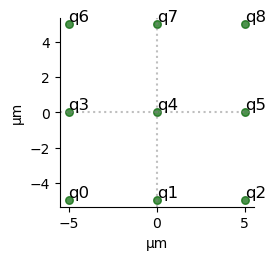

In [4]:
reg = Register.rectangle(3,3,5, prefix='q')
reg.draw()

In [22]:
U = 20 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -1.8 * U
delta_f = 1.8 * U
Omega_max = 1.45 * U  # btw 1.8-2 Mhz*2pi

T=1000
time_domain=np.linspace(0,T,1000)
print(delta_f,Omega_max)

226.1946710584651 182.212373908208


In [23]:
m=5
Omega_pts=(Omega_max*np.random.rand(m)).tolist()
delta_pts=(np.random.rand(m)*(delta_f-delta_0)+delta_0).tolist()

In [24]:
def interp_pulse_functions(Omega_pts,delta_pts,T):
    """Create control interpolated functions for Rabi frequency and detuning.

    Parameters
    ----------
    Omega_pts : list of floats
        Values of Omega at given times
    delta_pts : list of floats
        Values of delta at given times
    T : float
        Total driving time

    Returns
    -------
    tuple of functions:
        (Omega, delta)
    """
    m=len(Omega_pts)
    ti=np.linspace(0,T,m+2)

    cso = PchipInterpolator(ti,np.array([0.01]+Omega_pts+[0.01]))
    csd = PchipInterpolator(ti,np.array([delta_0]+delta_pts+[delta_f]))
    def Omega(t,*args):
        return cso(t)
    def delta(t,*args):
        return csd(t)
    return Omega,delta

In [25]:
Omega_func,delta_func=interp_pulse_functions(Omega_pts,delta_pts,T)
Omega,delta=np.array(Omega_func(time_domain)),np.array(delta_func(time_domain))

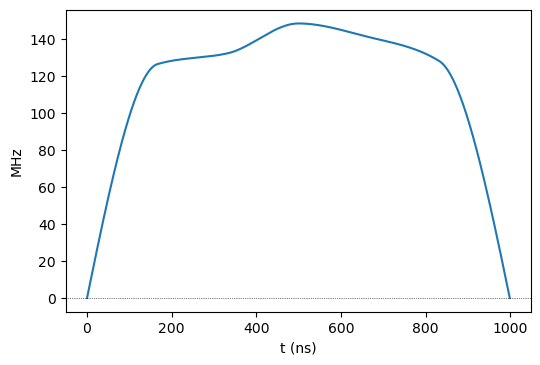

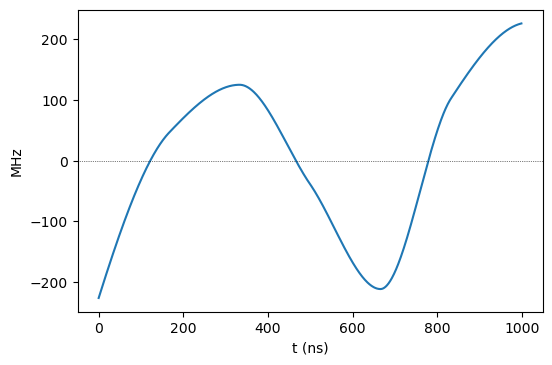

In [26]:
CustomWaveform(Omega).draw()
CustomWaveform(delta).draw()

In [10]:
P1=Pulse(CustomWaveform(Omega),CustomWaveform(delta),0)

In [43]:
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')
seq.declared_channels

{'ising': Rydberg.Global(Max Absolute Detuning: 5000 MHz, Max Amplitude: 250 MHz, Basis: 'ground-rydberg')}

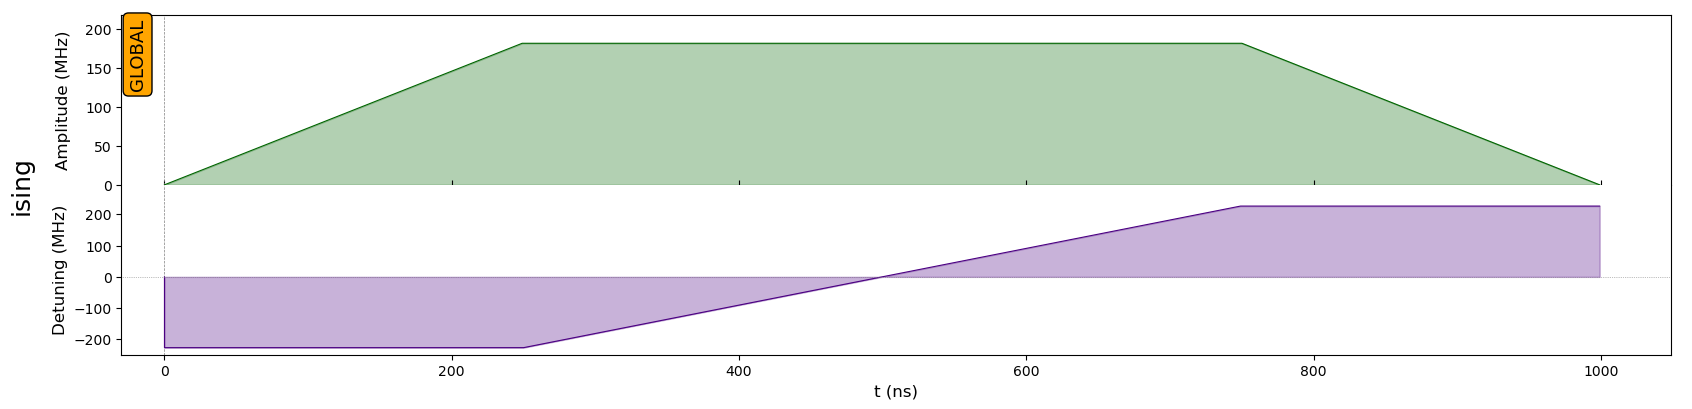

In [44]:
t_rise = 250
t_fall = 250
t_sweep = 500
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)
seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')
seq.draw()

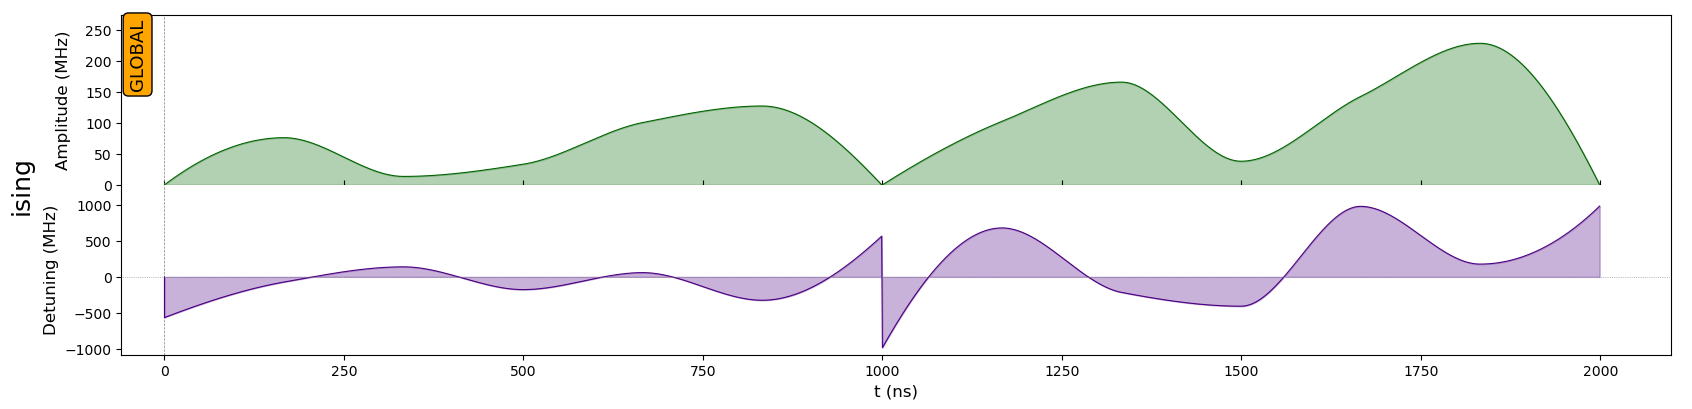

In [84]:
seq.add(P,'ising')
seq.draw()

In [45]:
simul = Simulation(seq)
occup_list=[]
simul.run(obs_list=occup_list, progress_bar=True)

No observable provided. Calculating state evolution...
10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.14s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.31s. Est. time left: 00:00:00:00
50.0%. Run time:   0.43s. Est. time left: 00:00:00:00
60.0%. Run time:   0.54s. Est. time left: 00:00:00:00
70.0%. Run time:   0.65s. Est. time left: 00:00:00:00
80.0%. Run time:   0.76s. Est. time left: 00:00:00:00
90.0%. Run time:   0.88s. Est. time left: 00:00:00:00
Total run time:   0.98s


In [46]:
def proba_from_state(state,rho_target=None,p=0.1,):
    """Get the states with their probability if the latter is greater than p if the state is a ket.
    Get the probability associated with rho_target if the state is a density matrix

    Parameters
    ----------
    state : Qobj ket or density matrix
        Qobj describing the state of the system
    rho_target : Qobj density matrix
        Target state
    p : float
        Minimum probability to classify a state significant

    """
    N=int(np.log2(state.shape[0]))
    if state.isket:
        proba=abs(np.array(state))**2
        indic=np.where(proba>=p)[0]
        Proba=[]
        for indi in indic:
            Proba+=['AF '+format(indi,'0{}b'.format(N))+' with P={:.4f}%'.format(proba[indi][0]*100)]
        return Proba
    elif state.isoper:
        print('AF with P={:.4f}%'.format(np.real(np.trace(rho_target*state)*100)))

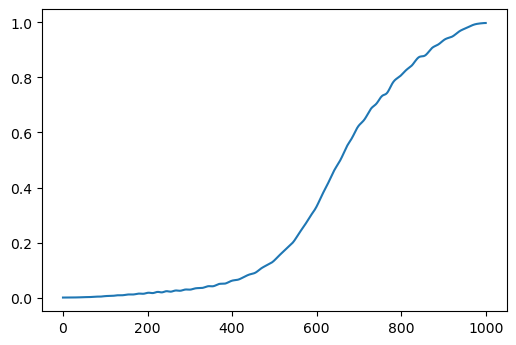

In [47]:
PSI=simul.output.states
plt.figure()
plt.plot(time_domain,[stg_mag(Qobj(psi,dims = [[512], [1]])) for psi in PSI])
plt.show()